# Headline

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from autoimpute.imputations import SingleImputer, MultipleImputer
from statsmodels.imputation import mice
from statsmodels.regression import linear_model as sm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import TransformerMixin



In [3]:
os.getcwd()

'C:\\Users\\Zachary\\desktop\\GA\\dsi_assignments\\project_2'

In [4]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')



In [5]:
display(test.head())
train.shape, test.shape


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


((2051, 81), (878, 80))

In [6]:
train['SalePrice'].mean()

181469.70160897123

## Checking for Nulls and Wrong Datatypes

In [7]:


test_null = pd.DataFrame(test.isnull().sum())

train_null = pd.DataFrame(train.isnull().sum())


test_null.drop(test_null[test_null[0] == 0].index, inplace = True)

train_null.drop(train_null[train_null[0] == 0].index, inplace = True)


test_null.rename(columns = {0:'test'}, inplace = True)

train_null.rename(columns = {0:'train'}, inplace = True)


nulls = pd.concat([test_null, train_null], axis = 1, sort = True)

display(nulls)

,test,train
Alley,820.0,1911.0
Bsmt Cond,25.0,55.0
Bsmt Exposure,25.0,58.0
Bsmt Full Bath,NaN,2.0
Bsmt Half Bath,NaN,2.0
Bsmt Qual,25.0,55.0
Bsmt Unf SF,NaN,1.0
BsmtFin SF 1,NaN,1.0
BsmtFin SF 2,NaN,1.0
BsmtFin Type 1,25.0,55.0


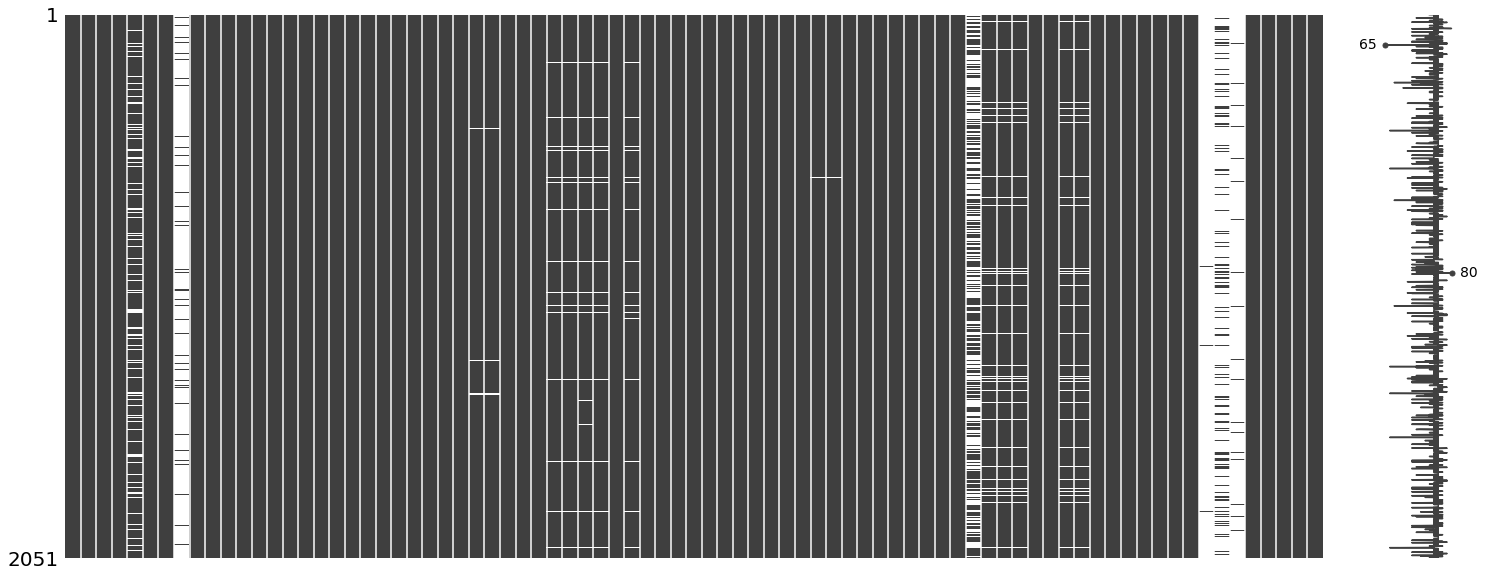

In [8]:
# null visualizing
msno.matrix(train);

***
##  Making Column Names Nice
***

In [9]:
train = train.rename(str.lower, axis = 'columns')
train.columns = train.columns.str.replace(' ', '_')


In [10]:
test = test.rename(str.lower, axis = 'columns')
test.columns = test.columns.str.replace(' ', '_')


***
## Combining Train and Test for Cleaning
***

In [11]:
# adding bunk saleprice column for 

test['saleprice'] = 0


# checking concat
with pd.option_context('max_columns', 999):
    display(pd.concat([train, test], sort = False).head())
    print(pd.concat([train, test]).shape)
    
# concating

dirty = pd.concat([train, test], sort = False)

for_eda = pd.concat([train, test], sort = False)

dirty.head()

dirty.reset_index(inplace = True)

with pd.option_context('display.max_rows', 999):
    display(dirty.dtypes)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


(2929, 81)


index                int64
id                   int64
pid                  int64
ms_subclass          int64
ms_zoning           object
lot_frontage       float64
lot_area             int64
street              object
alley               object
lot_shape           object
land_contour        object
utilities           object
lot_config          object
land_slope          object
neighborhood        object
condition_1         object
condition_2         object
bldg_type           object
house_style         object
overall_qual         int64
overall_cond         int64
year_built           int64
year_remod/add       int64
roof_style          object
roof_matl           object
exterior_1st        object
exterior_2nd        object
mas_vnr_type        object
mas_vnr_area       float64
exter_qual          object
exter_cond          object
foundation          object
bsmt_qual           object
bsmt_cond           object
bsmt_exposure       object
bsmtfin_type_1      object
bsmtfin_sf_1       float64
b

***
## Making Dummy Columns
***

In [12]:
# finding columns to dummy (nulls removed in each column)

dummiable = [col[0] for col  in pd.DataFrame.iteritems(dirty) if dirty[col[0]].dtypes == 'O']

print(dummiable)

display(dirty.head())

dirty = pd.get_dummies(dirty, columns = dummiable, drop_first=True)



dirty.head()



['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature', 'sale_type']


,index,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


,index,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,...,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
0,0,109,533352170,60,NaN,13517,6,8,1976,2005,...,0,0,0,0,0,0,0,0,0,1
1,1,544,531379050,60,43.0,11492,7,5,1996,1997,...,0,0,0,0,0,0,0,0,0,1
2,2,153,535304180,20,68.0,7922,5,7,1953,2007,...,0,0,0,0,0,0,0,0,0,1
3,3,318,916386060,60,73.0,9802,5,5,2006,2007,...,0,0,0,0,0,0,0,0,0,1
4,4,255,906425045,50,82.0,14235,6,8,1900,1993,...,0,0,0,0,0,0,0,0,0,1


***
## Imputing null values
***

In [13]:
# credit to https://github.com/jem1031/pandas-pipelines-custom-transformers for handling Pandas DataFrames with Sklearn
# transformers (my code is modified from theirs)




class DFImputer(TransformerMixin):
    # Imputer but for pandas DataFrames

    def __init__(self):
        self.imp = None
        self.statistics_ = None

    def fit(self, X, y=None):
        self.imp = IterativeImputer()
        self.imp.fit(X)
        
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Ximp = self.imp.transform(X)
        Xfilled = pd.DataFrame(Ximp, index=X.index, columns=X.columns)
        return Xfilled
    
imp = IterativeImputer(max_iter = 10, random_state = 0)


imput = DFImputer()







imput.fit(dirty)

dirty = imput.transform(dirty)

imput.fit(for_eda[['lot_frontage', 'lot_area', 'overall_qual',
                          'overall_cond','mas_vnr_area', 'bsmtfin_sf_1',
                          'bsmtfin_sf_2','bsmt_unf_sf','total_bsmt_sf',
                           'low_qual_fin_sf',
                           'gr_liv_area','bsmt_full_bath','bsmt_half_bath',
                           'full_bath','half_bath','bedroom_abvgr',
                           'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces',
                          'garage_cars','garage_area', 'wood_deck_sf',
                           'open_porch_sf', 'enclosed_porch',
                           'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'saleprice']])

for_eda = imput.transform(for_eda[['lot_frontage', 'lot_area', 'overall_qual',
                          'overall_cond','mas_vnr_area', 'bsmtfin_sf_1',
                          'bsmtfin_sf_2','bsmt_unf_sf','total_bsmt_sf',
                           'low_qual_fin_sf',
                           'gr_liv_area','bsmt_full_bath','bsmt_half_bath',
                           'full_bath','half_bath','bedroom_abvgr',
                           'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces',
                          'garage_cars','garage_area', 'wood_deck_sf',
                           'open_porch_sf', 'enclosed_porch',
                           'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'saleprice']])

# some data loss due to not using dummy variable to imput

***
## Splitting Back into Train Test and Outputing
***

In [14]:
train = dirty.iloc[:2051]
test = dirty.iloc[2051:]


print(train.shape, test.shape)


pd.DataFrame.to_csv(train, 'cleaned_datasets/train.csv', index = False)

pd.DataFrame.to_csv(test, 'cleaned_datasets/test.csv', index = False)



(2051, 260) (878, 260)



***
# EDA
***

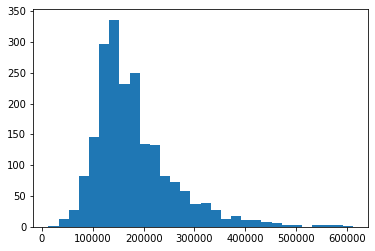

In [15]:
plt.hist(train['saleprice'], bins = 30);

In [16]:
train['lot_area'].mean()

10065.20819112628

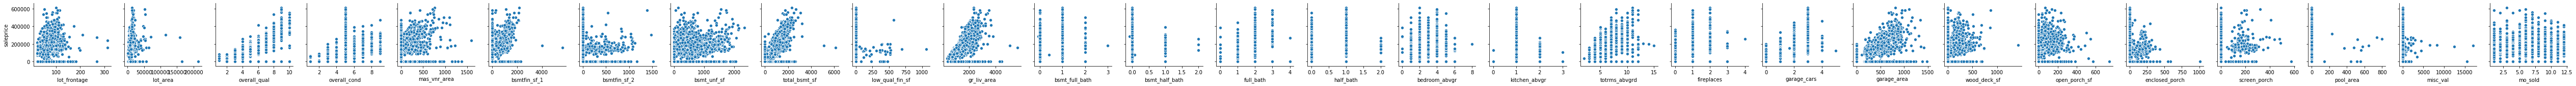

In [17]:
# plt.figure(figsize=(100,100));


sns.pairplot(for_eda, x_vars=for_eda.drop(columns = 'saleprice').columns, y_vars=['saleprice']);



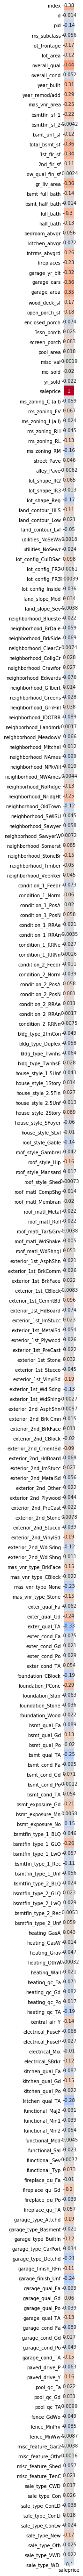

In [18]:
plt.figure(figsize=(400,100))


sns.heatmap(dirty.corr()[['saleprice']], cmap='coolwarm', annot=True, vmin=-1, square=True,cbar=False);

In [19]:
output = pd.DataFrame({'Id': test['id']})

output['SalePrice'] = 181469

display(output.head())



pd.DataFrame.to_csv(output, 'submissions/naive.csv', index = False)

output.dtypes

,Id,SalePrice
2051,2658.0,181469
2052,2718.0,181469
2053,2414.0,181469
2054,1989.0,181469
2055,625.0,181469


Id           float64
SalePrice      int64
dtype: object